In [3]:
for p in ("Knet","ArgParse","Images")
    Pkg.installed(p) == nothing && Pkg.add(p)
end
include(Pkg.dir("Knet","data","imagenet.jl"))  #imagenet.jl includes matconvnet function etc.

#using Knet, ImageTransformations
using Knet, Images, FileIO

In [4]:
function img_normalize!(img, model_mean)
    for i in 1:size(img, 3)
        img[:,:,i] = (img[:,:,i] .- model_mean[i])
    end
    return img
end

function preprocess(img; new_size=256)
    height = size(img,1); width = size(img,2);
    if min(height, width) == new_size
        img2 = img
    elseif height <= width
    #Resize the image
        img2 = imresize(img, new_size, Int(round(new_size*width/height)))
    else
        img2 = imresize(img, Int(round(new_size*height/width)), new_size)
    end
    #convert the image to 3D Tensor
    img2 = channelview(img2);
    img2 = permutedims(img2, [3,2,1])    #result is a new array
    img2 = Array{Float64}(img2);
    #Normalize the image tensor by subtracting the mean and dividing with the standard dev. for each channel
    CNN_MEAN = Array{Float64}(averageImage./255)
    img_normalize!(img2, CNN_MEAN)   
    #put extra dimension at the end of the tensor. size becomes [H,W,C,1]
    img3 = reshape(img2, (size(img2)..., 1))  
    img3 = permutedims(img3, [2,1,3,4])
end

function postprocess(img)
    img = reshape(img, (size(img)...)[1:end-1])
    CNN_MEAN = Array{Float64}(averageImage./255)
    img_normalize!(img, -1*CNN_MEAN)
    clamp!(img, 0,1)
    img = Array{FixedPointNumbers.Normed{UInt8,8}}(img)
    img2 = colorview(RGB, permutedims(img, [3,1,2]))
    return img2
end

postprocess (generic function with 1 method)

In [19]:
function display_output(img)
    output = postprocess(cpu_type(copy(img)))
    return output
end

display_output (generic function with 1 method)

In [5]:
cpu_type = Array{Float64}
#dtype = Array{Float64}
#if you have GPU, uncomment below line instead
dtype = KnetArray{Float64}

Knet.KnetArray{Float64,N} where N

In [6]:
# This procedure makes pretrained MatConvNet VGG parameters convenient for Knet
function get_params(CNN, atype; last_layer="pool5")
    layers = CNN["layers"]
    weights, operations, derivatives = [], [], []
    for l in layers
        get_layer_type(x) = startswith(l["name"], x)
        last_layer != nothing && get_layer_type(last_layer) && break
        operation = filter(x -> get_layer_type(x), LAYER_TYPES)[1]
        push!(operations, operation)
        push!(derivatives, haskey(l, "weights") && length(l["weights"]) != 0)
        if derivatives[end]
            w = copy(l["weights"])
            if operation == "conv"
                w[2] = reshape(w[2], (1,1,length(w[2]),1))
            elseif operation == "fc"
                w[1] = transpose(mat(w[1]))
            end
            push!(weights, w)
        end
    end
    map(w -> map(wi->convert(atype,wi), w), weights), operations, derivatives
end

# get convolutional network to compute the outputs of five layers(conv1,relu1,conv2,relu2...,conv5,relu5)
function get_convnet(weights, operations, derivatives)
    function convnet(xs)     #xs is the input image to the network
        outputs = []
        i, j = 1, 1
        num_weights, num_operations = length(weights), length(operations)
        while i <= num_operations && j <= num_weights
            if derivatives[i]
                xs = forw(xs, operations[i], weights[j])
                j += 1
            else
                xs = forw(xs, operations[i])
            end
            if operations[i] in ("conv", "relu")
                push!(outputs, xs)
            end
            i += 1
        end
        return outputs
    end
end

# convolutional network operations
convx(x,w) = conv4(w[1], x; padding=1, mode=1) .+ w[2]
if VERSION >= v"0.6.0"
    relux(x) = relu.(x)
else
    relux(x) = relu(x)
end
poolx = pool   #max pooling
#poolx(x) = pool(x, mode=1)  #avg pooling
probx(x) = x
fcx(x,w) = w[1] * mat(x) .+ w[2]
tofunc(op) = eval(parse(string(op, "x")))
forw(x,op) = tofunc(op)(x)
forw(x,op,w) = tofunc(op)(x,w)

const LAYER_TYPES = ["conv", "relu", "pool", "fc", "prob"] 
global _vggcache
VGG_model = "imagenet-vgg-verydeep-16"
if !isdefined(:_vggcache); _vggcache=Dict(); end
if !haskey(_vggcache, VGG_model)
    #Load the pre-trained VGG-16 model
    #const vggurl = "http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-16.mat"
    vgg = matconvnet(VGG_model)
    params = get_params(vgg, dtype)
    convnet = get_convnet(params...)
    averageImage = reshape(convert(Array{Float64},vgg["meta"]["normalization"]["averageImage"]), (1,3))
    _vggcache[VGG_model] = vgg, params, convnet, averageImage;
else
    vgg, params, convnet, averageImage = _vggcache[VGG_model];
end;


INFO: Loading imagenet-vgg-verydeep-16.mat...


In [7]:
function content_loss(content_weight, content_current, content_original)
    #=
    compute the content loss
    content weight: coefficient of the content_loss in the total loss
    content_current: features of the current image. shape is (H_l, W_l, C_l, 1)
    content_target: features of the content image. shape is (H_l, W_l, C_l ,1)
    returns:
    content_loss: a scalar loss value
    =#
    Hl, Wl, Cl, Q = size(content_current)
    content_losses = content_weight * sum((content_current - content_original).^2) /  (4*Hl*Wl* Cl)
    return content_losses
end

function gram_matrix(features, normalize=true)
    #=
    compute the Gram matrix for one layer of network from features
    features: a batch of N input image features. shape (H, W, C, N)
    normalize: if true, normalize the Gram matrix by dividing by the number of neurons (H*W*C)
    gram_mat: Gram matrices for the N input image features. shape (C, C, N)
    =#
    H, W, C, N = size(features)
    feat_reshaped = reshape(features, (H*W, C))  
    gram_mat = transpose(feat_reshaped) * feat_reshaped  #shape:(C,C)
    if normalize
        return gram_mat ./ (2*H*W*C)
    else
        return gram_mat
    end
end
    

gram_matrix (generic function with 2 methods)

In [8]:
"""
Compute the style loss at a set of layers
Inputs:
 - feats: List of features obtained at conv layers of the current image, as obtained by get_convnet function.
 - style_layers: List of layer indices into feats, giving the layers to be included in the style loss
 - style_targets: List having the same length as style_layers. This includes the gram matrices computed for feats
 - style_weights: List having the same lenght as style_layers. This stores the weights of the style_layers in loss eqn.

Returns:
 - style_loss: The scalar style loss obtained by taking the weighted sum of style losses in each layer 

"""

function style_loss(feats, style_layers, style_targets, style_weights)
    style_losses = Float64(0.0)
    for i in 1:length(style_layers)
        gram_mat = gram_matrix(feats[style_layers[i]])
        style_losses = style_losses + style_weights[i]*sum((gram_mat - style_targets[i]).^2)
    end
    return style_losses
end


style_loss

In [9]:
"""
Compute total variation loss.
    
Inputs:
- img: input image, size (H, W, 3, 1)
- tv_weight: Scalar giving the weight w_t to use for the TV loss.
    
Returns:
- loss: Variable holding a scalar giving the total variation loss
    for img weighted by tv_weight.
"""

#Total-variation regularization
function tv_loss(img, tv_weight)
    img = Array(img)
    Hl, Wl, Cl, Q = size(img)
    ver_comp = sum((img[2:end, :, :, :] - img[1:end-1, :, :, :]).^2)
    hor_comp = sum((img[:, 2:end, :, :] - img[:, 1:end-1, :, :]).^2)
    losses = tv_weight .* (ver_comp + hor_comp) /  (4*Hl*Wl* Cl)
    return losses
end


tv_loss

In [10]:
function loss(img_var, content_weight,content_layer,content_target, style_layers, style_targets, style_weights, tv_weight)
    feats = convnet(img_var)
    # Compute loss    
    c_loss = content_loss(content_weight, feats[content_layer], content_target)
    s_loss = style_loss(feats, style_layers, style_targets, style_weights)
    t_loss = tv_loss(img_var, tv_weight)
    total_loss = c_loss + s_loss + t_loss
    return total_loss
end

loss_gradient = gradloss(loss)

(::gradfun) (generic function with 1 method)

In [24]:
 """
    Run style transfer!
    
    Inputs:
    - content_image: filename of content image
    - style_image: filename of style image
    - image_size: size of smallest image dimension (used for content loss and generated image)
    - style_size: size of smallest style image dimension
    - content_layer: layer to use for content loss
    - content_weight: weighting on content loss
    - style_layers: list of layers to use for style loss
    - style_weights: list of weights to use for each layer in style_layers
    - tv_weight: weight of total variation regularization term
    - init_random: initialize the starting image to uniform random noise
    """
iterations = 500

function style_transfer(content_image, style_image, image_size, style_size, content_layer, content_weight,
                   style_layers, style_weights, tv_weight, init_random = false)
    # Extract features for the content image
    content_img = preprocess(load(content_image), new_size=image_size)
    content_img_var = dtype(content_img)
    feats = convnet(content_img_var)
    content_target = copy(feats[content_layer])
    
    # Extract features for the style image
    style_img = preprocess(load(style_image), new_size=style_size)
    style_img_var = dtype(style_img)
    feats = convnet(style_img_var)
    style_targets = []
    for i in style_layers
        push!(style_targets, gram_matrix(copy(feats[i])))
    end
    # Note that we are optimizing the pixel values of the image
    # Initialize output image to content image or noise
    if init_random
        #img_var = dtype(rand(size(content_img)))   #uniform r.v. between 0 and 1
        img_var = dtype(randn(size(content_img)))  #gaussian noise (mean:0, var:1)
    else
        img_var = dtype(copy(content_img))
    end
    
    # Set up optimization hyperparameters
    initial_lr = 0.03   #0.03 is good for size:256.and 0.01 is good for 512.    
    BETA_1=0.9
    BETA_2=0.999
    EPS=1e-08
    #the img_var will be updated using Adam
    optim = optimizers(img_var, Adam; lr=initial_lr, beta1=BETA_1, beta2=BETA_2, eps=EPS)
    
    #TRAINING: TAKE DERIVATIVE W.R.T. img_var and update img_var
    #initialize the loss_vector so that we can plot the loss in each iteration later
    loss_vector = []
    info("Training...")
    for t in 1:iterations
        grads, loss_value = loss_gradient(img_var, content_weight,content_layer,content_target, 
            style_layers, style_targets, style_weights, tv_weight)
        
        update!(img_var, grads, optim)
        
        #report errors in every five iterations
        if t % 50 == 0
                println((:iteration, t, :loss, loss_value))
        end
        push!(loss_vector, loss_value)
    end
    return (img_var, loss_vector);
end

style_transfer

In [11]:
content_img_def = "demo_images/sculpture1.jpg"
style_img_def = "demo_images/the_scream.jpg"

"demo_images/the_scream.jpg"

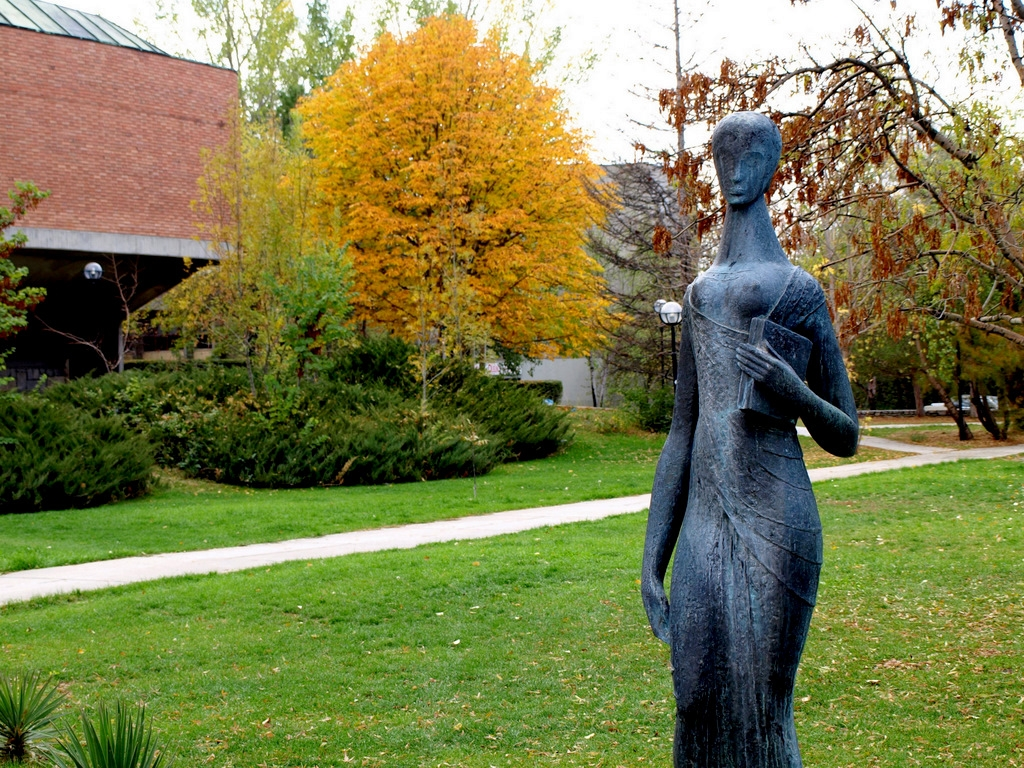

In [14]:
load(content_img_def)

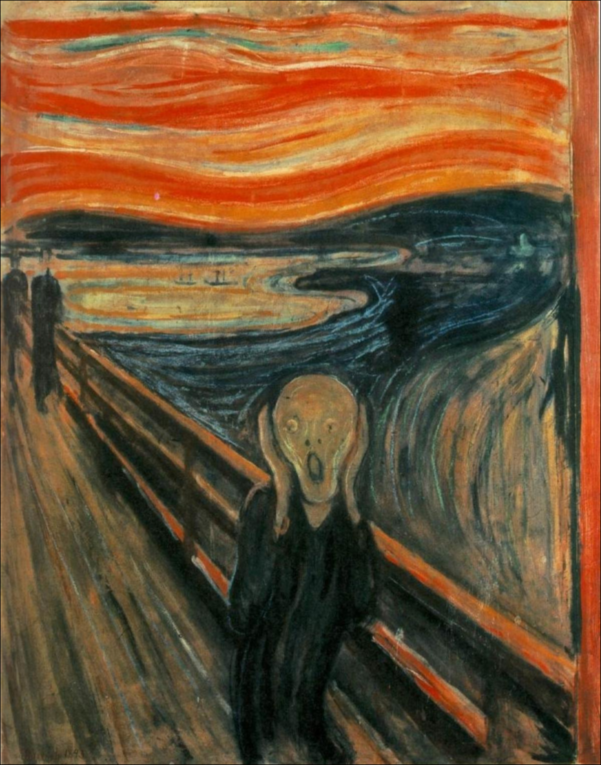

In [16]:
load(style_img_def)

INFO: Training...


(:iteration, 50, :loss, 69.46225302026892)
(:iteration, 100, :loss, 44.21169523556544)
(:iteration, 150, :loss, 51.41216228653101)
(:iteration, 200, :loss, 37.97126735123042)
(:iteration, 250, :loss, 38.19544718998477)
(:iteration, 300, :loss, 32.474834387557415)
(:iteration, 350, :loss, 41.414817008734595)
(:iteration, 400, :loss, 43.93831538960311)
(:iteration, 450, :loss, 32.84554589976385)
(:iteration, 500, :loss, 30.429643949051027)
100.534901 seconds (3.43 M allocations: 19.637 GiB, 1.45% gc time)


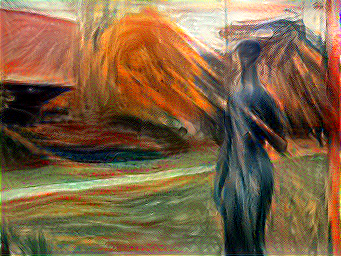

In [29]:
#Demo-1. Style transfer.
image_size_default = style_size_default = 256
content_lay_default = 18    #relu4_2
style_lay_default = (3, 7, 12, 17, 23);  #conv1_2, conv2_2, conv3_2, conv4_2, conv5_2

content_weights_default = 10*Float64(1.0)
style_weights_default = 10*Array{Float64}([0.2, 2*0.2, 3*0.2, 4*0.2, 5*0.2])
tv_weight_def = 8*Float64(1.0);
@time (img1, loss_vector1) = style_transfer(content_img_def, style_img_def, image_size_default, style_size_default, content_lay_default, 
    content_weights_default, style_lay_default, style_weights_default, tv_weight_def);
output1 = display_output(img1)

INFO: Training...


(:iteration, 50, :loss, 0.917386490793537)
(:iteration, 100, :loss, 0.12999230395459171)
(:iteration, 150, :loss, 0.0426676123308479)
(:iteration, 200, :loss, 0.029281664991296363)
(:iteration, 250, :loss, 0.026796952698636384)
(:iteration, 300, :loss, 0.026308302175475817)
(:iteration, 350, :loss, 0.02621684567642078)
(:iteration, 400, :loss, 0.026201565359782564)
(:iteration, 450, :loss, 0.02619936451931852)
(:iteration, 500, :loss, 0.02619909421130614)
100.138476 seconds (3.43 M allocations: 19.637 GiB, 1.45% gc time)


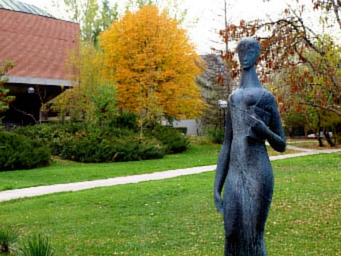

In [27]:
#Demo-2. Content reconstruction. Note the random initialization.
iterations = 300
image_size_default = style_size_default = 256
#content_lay_default = 18    #relu4_2
content_lay_default = 1    #conv1_1
style_lay_default = (3, 7, 12, 17, 23);  #conv1_2, conv2_2, conv3_2, conv4_2, conv5_2

content_weights_default = 10*Float64(1.0)
style_weights_default = Array{Float64}([0.0, 0.0, 0.0, 0.0, 0.0])
tv_weight_def = 8*Float64(1.0);
@time (img2, loss_vector2) = style_transfer(content_img_def, style_img_def, image_size_default, style_size_default, content_lay_default, 
    content_weights_default, style_lay_default, style_weights_default, tv_weight_def, true);
output2 = display_output(img2)

In [ ]:
#iterations = 
#Demo-3. Style reconstruction.Note the random initialization.
image_size_default = style_size_default = 256
content_lay_default = 18    #relu4_2
style_lay_default = (3, 7, 12, 17, 23);  #conv1_2, conv2_2, conv3_2, conv4_2, conv5_2

content_weights_default = Float64(0.0)
style_weights_default = 10*Array{Float64}([0.2, 2*0.2, 3*0.2, 4*0.2, 5*0.2])
tv_weight_def = 0*Float64(1.0);
@time (img3, loss_vector3) = style_transfer(content_img_def, style_img_def, image_size_default, style_size_default, content_lay_default, 
    content_weights_default, style_lay_default, style_weights_default, tv_weight_def, true);
output3 = display_output(img3)

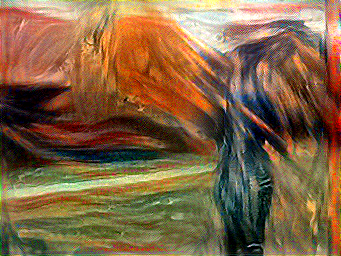

In [32]:
output3 = display_output(img1)